In [20]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns


import nltk
import unicodedata
import scipy.stats as stats

## Orginal Df

In [17]:
train_df = pd.read_csv('master_train_data.csv', index_col=0).reset_index().drop(columns='index')

In [18]:
train_df 

,id,prompt_id,text,generated
0,C8620D9D22DC,1475,Having students of different ages in the same ...,1
1,D8D84A2E4CE0,1779,After researching examples of successful group...,1
2,DD279F25DC1F,1889,"For many students and teachers, a four-day sch...",1
3,6574B5B58A11,76,"Delve into what motivates you to take action, ...",1
4,87901eed,1,"Dear Senator, If one could sum up the definiti...",0
...,...,...,...,...
3794,722C353F2831,229,Honesty is a fundamental part of any healthy r...,1
3795,da14ac70,1,"Dear Senator, As you may know, there is a huge...",0
3796,5b1c86a2,1,The electoral collage should be disbanded. Not...,0
3797,CE7E3C75BAF8,1589,First impressions often form the basis for how...,1


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3799 non-null   int64 
 1   id          3799 non-null   object
 2   prompt_id   3799 non-null   int64 
 3   text        3799 non-null   object
 4   generated   3799 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 148.5+ KB


In [11]:
train_df.generated.value_counts(normalize=True)

1    0.638063
0    0.361937
Name: generated, dtype: float64

## Stemmed df thanks Fermin :) 

In [24]:
df2 = pd.read_csv('data_stemmed.csv', index_col=0).reset_index().drop(columns='index')

In [25]:
df2

,text,generated
0,"['have', 'student', 'of', 'differ', 'age', 'in...",1
1,"['after', 'research', 'exampl', 'of', 'success...",1
2,"['for', 'mani', 'student', 'and', 'teacher', '...",1
3,"['delv', 'into', 'what', 'motiv', 'you', 'to',...",1
4,"['dear', 'senat', 'if', 'one', 'could', 'sum',...",0
...,...,...
3794,"['honesti', 'is', 'a', 'fundament', 'part', 'o...",1
3795,"['dear', 'senat', 'as', 'you', 'may', 'know', ...",0
3796,"['the', 'elector', 'collag', 'should', 'be', '...",0
3797,"['first', 'impress', 'often', 'form', 'the', '...",1


In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3799 non-null   object
 1   generated  3799 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 59.5+ KB


In [27]:
df2.generated.value_counts(normalize=True)

1    0.638063
0    0.361937
Name: generated, dtype: float64

## Train Val Test

In [23]:
def train_val_test(df, stratify=False, target=None):
    train_validate, test = train_test_split(df,
                                            random_state=706,
                                            train_size=0.8,
                                            stratify=df[target] if stratify else None)
    train, val = train_test_split(train_validate,
                                  random_state=706,
                                  train_size=0.7,
                                  stratify=train_validate[target] if stratify else None)
    return train, val, test

In [28]:
train, val, test = train_val_test(df2, stratify=True,target='generated')

In [32]:
train.shape, val.shape, test.shape

((2127, 2), (912, 2), (760, 2))

In [33]:
train.head()

,text,generated
657,"['it', ""'"", 's', 'the', 'tuesday', 'after', 't...",0
3127,"['ralph', 'waldo', 'emerson', 'wa', 'a', '19th...",1
2193,"['car', 'are', 'start', 'to', 'becom', 'more',...",0
3467,"['imagin', 'that', 'the', 'presid', 'the', 'ma...",0
2463,"['make', 'good', 'decis', 'can', 'be', 'diffic...",1


In [41]:
ai_words =' '.join(train[train.generated==1]['text'])
student_words = ' '.join(train[train.generated==0]['text'])
all_words = ' '.join(train['text'])

In [68]:
ai_word_list = ai_words.split(" ")
student_word_list = student_words.split(" ")
all_word_list = all_words.split(" ")

In [69]:
ai_freq = pd.Series(ai_word_list).value_counts()
student_freq = pd.Series(student_word_list).value_counts()
all_freq = pd.Series(all_word_list).value_counts()

In [70]:
ai_freq

'to',           12180
'and',          11097
'the',           9968
'a',             7101
'of',            6960
                ...  
'sakura',           1
'cherri',           1
'akihabara',        1
'stall',            1
'puzzl']            1
Length: 7320, dtype: int64

In [71]:
word_counts = pd.concat([ai_freq, student_freq, all_freq], axis=1
         ).fillna(0
                 ).astype(int)
word_counts.columns = ['ai','student', 'all']
word_counts.head()

,ai,student,all
"'to',",12180,13361,25541
"'and',",11097,9503,20600
"'the',",9968,27125,37093
"'a',",7101,10631,17732
"'of',",6960,12354,19314


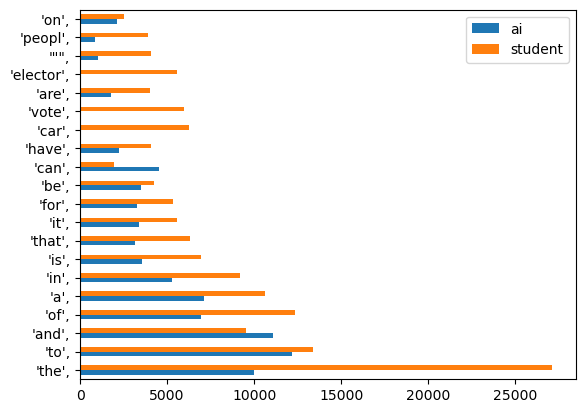

In [72]:
word_counts.sort_values('all', ascending=False
                       )[['ai','student']].head(20).plot.barh()
plt.show()

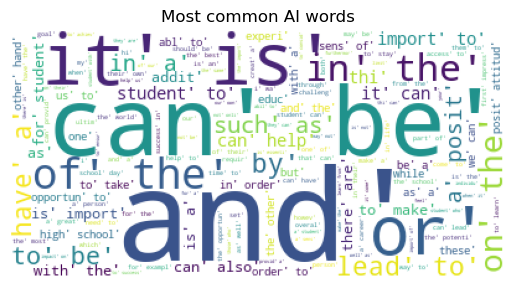

In [73]:
img = WordCloud(background_color='White',
         ).generate(' '.join(ai_word_list))
plt.imshow(img)
plt.axis('off')
plt.title('Most common AI words')
plt.show()

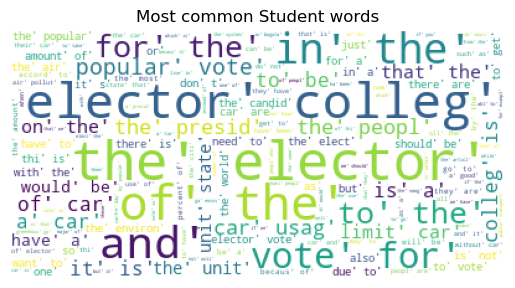

In [60]:
img = WordCloud(background_color='White',
         ).generate(' '.join(student_word_list))
plt.imshow(img)
plt.axis('off')
plt.title('Most common Student words')
plt.show()